In [1]:
using DiffEqFlux, OrdinaryDiffEq, Flux, Optim, Plots, CUDA, DiffEqSensitivity
CUDA.allowscalar(false) # Makes sure no slow operations are occuring

┌ Info: Precompiling DiffEqFlux [aae7a2af-3d4f-5e19-a356-7da93b79d9d0]
└ @ Base loading.jl:1260
┌ Warning: `haskey(::TargetIterator, name::String)` is deprecated, use `Target(; name = name) !== nothing` instead.
│   caller = llvm_compat(::VersionNumber) at compatibility.jl:176
└ @ CUDAnative ~/.julia/packages/CUDAnative/ierw8/src/compatibility.jl:176
┌ Warning: `haskey(::TargetIterator, name::String)` is deprecated, use `Target(; name = name) !== nothing` instead.
│   caller = llvm_compat(::VersionNumber) at compatibility.jl:176
└ @ CUDAnative /home/kit/scc/yy3406/.julia/packages/CUDAnative/ierw8/src/compatibility.jl:176
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


In [2]:
# Generate Dataset
u0 = Float32[2.0; 0.0]
datasize = 30
tspan = (0.0f0, 1.5f0)
tsteps = range(tspan[1], tspan[2], length = datasize)
function trueODEfunc(du, u, p, t)
    true_A = [-0.1 2.0; -2.0 -0.1]
    du .= ((u.^3)'true_A)'
end
prob_trueode = ODEProblem(trueODEfunc, u0, tspan)
# Make the data into a GPU-based array if the user has a GPU
ode_data = solve(prob_trueode, Tsit5(), saveat = tsteps)

retcode: Success
Interpolation: 1st order linear
t: 30-element Array{Float32,1}:
 0.0
 0.05172414
 0.10344828
 0.15517241
 0.20689656
 0.25862068
 0.31034482
 0.36206895
 0.41379312
 0.46551725
 0.51724136
 0.5689655
 0.62068963
 ⋮
 0.9310345
 0.98275864
 1.0344827
 1.0862069
 1.137931
 1.1896552
 1.2413793
 1.2931035
 1.3448275
 1.3965517
 1.4482758
 1.5
u: 30-element Array{Array{Float32,1},1}:
 [2.0, 0.0]
 [1.9465027, 0.7988313]
 [1.7417798, 1.4647328]
 [1.2383714, 1.8087709]
 [0.5771257, 1.8646537]
 [-0.079902545, 1.8360972]
 [-0.70109916, 1.7947617]
 [-1.2428578, 1.661995]
 [-1.5910622, 1.332026]
 [-1.71014, 0.8458141]
 [-1.7087564, 0.32341152]
 [-1.6840492, -0.18173005]
 [-1.6495321, -0.6622408]
 ⋮
 [0.21684329, -1.5469323]
 [0.5906021, -1.5198126]
 [0.9318935, -1.4542947]
 [1.203629, -1.3096923]
 [1.3721485, -1.0740426]
 [1.4424082, -0.7778038]
 [1.4523968, -0.4605107]
 [1.4403157, -0.14678831]
 [1.4251535, 0.15739423]
 [1.4068755, 0.4513812]
 [1.3702219, 0.72869843]
 [1.2921383,

In [3]:
ode_data = gpu(ode_data)

2×30 CuArrays.CuArray{Float32,2,Nothing}:
 2.0  1.9465    1.74178  1.23837  0.577126  …  1.40688   1.37022   1.29214
 0.0  0.798831  1.46473  1.80877  1.86465      0.451381  0.728698  0.972098

In [4]:
dudt2 = FastChain((x, p) -> x.^3,
                  FastDense(2, 50, tanh),
                  FastDense(50, 2))
u0 = Float32[2.0; 0.0] |> gpu
p = initial_params(dudt2) |> gpu
prob_neuralode = NeuralODE(dudt2, tspan, Tsit5(), saveat = tsteps)

(::NeuralODE{FastChain{Tuple{var"#3#4",FastDense{typeof(tanh),DiffEqFlux.var"#initial_params#85"{typeof(Flux.glorot_uniform),typeof(Flux.zeros),Int64,Int64}},FastDense{typeof(identity),DiffEqFlux.var"#initial_params#85"{typeof(Flux.glorot_uniform),typeof(Flux.zeros),Int64,Int64}}}},Array{Float32,1},Nothing,Tuple{Float32,Float32},Tuple{Tsit5},Base.Iterators.Pairs{Symbol,StepRangeLen{Float32,Float64,Float64},Tuple{Symbol},NamedTuple{(:saveat,),Tuple{StepRangeLen{Float32,Float64,Float64}}}}}) (generic function with 4 methods)

In [6]:
u0

2-element CuArrays.CuArray{Float32,1,Nothing}:
 2.0
 0.0

In [7]:
function predict_neuralode(p)
    gpu(prob_neuralode(u0,p))
end

function loss_neuralode(p)
    pred = predict_neuralode(p)
    loss = sum(abs2, ode_data .- pred)
    return loss, pred
end

loss_neuralode (generic function with 1 method)

In [8]:
list_plots = []
iter = 0
callback = function (p, l, pred; doplot = false)
    global list_plots, iter
    if iter == 0
        list_plots = []
    end
    iter += 1
    display(l)
    # plot current prediction against data
    plt = scatter(tsteps, Array(ode_data[1,:]), label = "data")
    scatter!(plt, tsteps, Array(pred[1,:]), label = "prediction")
    push!(list_plots, plt)
    if doplot
        display(plot(plt))
    end
    return false
end

#5 (generic function with 1 method)

In [9]:
result_neuralode = DiffEqFlux.sciml_train(loss_neuralode, p, ADAM(0.05), cb = callback, maxiters = 300)

202.15897f0

┌ Warning: `Target(triple::String)` is deprecated, use `Target(; triple = triple)` instead.
│   caller = ip:0x0
└ @ Core :-1
loss: 202:   0%|▏                                        |  ETA: 0:00:40

122.541565f0

loss: 123:   1%|▎                                        |  ETA: 0:06:50

111.29388f0

loss: 111:   1%|▍                                        |  ETA: 0:04:28

109.91441f0

loss: 110:   1%|▌                                        |  ETA: 0:03:41

107.93821f0

loss: 108:   2%|▋                                        |  ETA: 0:03:16

104.11818f0

loss: 104:   2%|▉                                        |  ETA: 0:02:46

99.83991f0

loss: 99.8:   2%|█                                        |  ETA: 0:02:35

96.96121f0

loss: 97:   3%|█▏                                       |  ETA: 0:02:23

95.507706f0

loss: 95.5:   3%|█▎                                       |  ETA: 0:02:09

94.72954f0

loss: 94.7:   3%|█▍                                       |  ETA: 0:02:02

94.02513f0

loss: 94:   4%|█▌                                       |  ETA: 0:01:55

93.038666f0

loss: 93:   4%|█▋                                       |  ETA: 0:01:50

91.605774f0

loss: 91.6:   4%|█▊                                       |  ETA: 0:01:46

89.69977f0

loss: 89.7:   5%|█▉                                       |  ETA: 0:01:45

87.35658f0

loss: 87.4:   5%|██                                       |  ETA: 0:01:40

84.59556f0

loss: 84.6:   5%|██▏                                      |  ETA: 0:01:39

81.35743f0

loss: 81.4:   6%|██▎                                      |  ETA: 0:01:36

77.51358f0

loss: 77.5:   6%|██▌                                      |  ETA: 0:01:33

72.945526f0

loss: 72.9:   6%|██▋                                      |  ETA: 0:01:32

67.63504f0

loss: 67.6:   7%|██▊                                      |  ETA: 0:01:30

61.642204f0

loss: 61.6:   7%|██▉                                      |  ETA: 0:01:27

54.930435f0

loss: 54.9:   7%|███                                      |  ETA: 0:01:27

48.29722f0

loss: 48.3:   8%|███▏                                     |  ETA: 0:01:27

42.714783f0

loss: 42.7:   8%|███▎                                     |  ETA: 0:01:25

37.918163f0

loss: 37.9:   8%|███▍                                     |  ETA: 0:01:24

34.721107f0

loss: 34.7:   9%|███▌                                     |  ETA: 0:01:24

35.73307f0

loss: 35.7:   9%|███▊                                     |  ETA: 0:01:24

33.69582f0

loss: 33.7:   9%|███▉                                     |  ETA: 0:01:24

22.609257f0

loss: 22.6:  10%|███▉                                     |  ETA: 0:01:23

34.075645f0

loss: 34.1:  10%|████▏                                    |  ETA: 0:01:22

20.0629f0

loss: 20.1:  10%|████▎                                    |  ETA: 0:01:23

22.242775f0

loss: 22.2:  11%|████▍                                    |  ETA: 0:01:22

23.839046f0

loss: 23.8:  11%|████▌                                    |  ETA: 0:01:21

24.867561f0

loss: 24.9:  11%|████▋                                    |  ETA: 0:01:21

26.482428f0

loss: 26.5:  12%|████▊                                    |  ETA: 0:01:21

27.078316f0

loss: 27.1:  12%|████▉                                    |  ETA: 0:01:20

26.861378f0

loss: 26.9:  12%|█████                                    |  ETA: 0:01:19

26.53903f0

loss: 26.5:  13%|█████▏                                   |  ETA: 0:01:19

24.937872f0

loss: 24.9:  13%|█████▍                                   |  ETA: 0:01:18

23.511818f0

loss: 23.5:  13%|█████▌                                   |  ETA: 0:01:18

21.484346f0

loss: 21.5:  14%|█████▋                                   |  ETA: 0:01:17

19.432575f0

loss: 19.4:  14%|█████▊                                   |  ETA: 0:01:16

17.545906f0

loss: 17.5:  14%|█████▉                                   |  ETA: 0:01:16

15.415742f0

loss: 15.4:  15%|██████                                   |  ETA: 0:01:16

13.055265f0

loss: 13.1:  15%|██████▏                                  |  ETA: 0:01:15

11.330298f0

loss: 11.3:  15%|██████▎                                  |  ETA: 0:01:15

13.545893f0

loss: 13.5:  16%|██████▍                                  |  ETA: 0:01:15

13.124685f0

loss: 13.1:  16%|██████▌                                  |  ETA: 0:01:15

8.971689f0

loss: 8.97:  16%|██████▋                                  |  ETA: 0:01:14

9.346194f0

loss: 9.35:  17%|██████▊                                  |  ETA: 0:01:14

10.135221f0

loss: 10.1:  17%|███████                                  |  ETA: 0:01:14

9.875582f0

loss: 9.88:  17%|███████▏                                 |  ETA: 0:01:13

9.032544f0

loss: 9.03:  18%|███████▎                                 |  ETA: 0:01:13

7.773587f0

loss: 7.77:  18%|███████▍                                 |  ETA: 0:01:12

7.1876945f0

loss: 7.19:  18%|███████▌                                 |  ETA: 0:01:12

7.082433f0

loss: 7.08:  19%|███████▋                                 |  ETA: 0:01:12

7.0456533f0

loss: 7.05:  19%|███████▊                                 |  ETA: 0:01:11

6.5384517f0

loss: 6.54:  19%|███████▉                                 |  ETA: 0:01:11

6.19326f0

loss: 6.19:  20%|████████                                 |  ETA: 0:01:11

6.3818083f0

loss: 6.38:  20%|████████▎                                |  ETA: 0:01:11

6.0566664f0

loss: 6.06:  20%|████████▍                                |  ETA: 0:01:10

5.1566544f0

loss: 5.16:  21%|████████▌                                |  ETA: 0:01:10

4.844838f0

loss: 4.84:  21%|████████▋                                |  ETA: 0:01:10

5.091839f0

loss: 5.09:  21%|████████▊                                |  ETA: 0:01:09

5.096726f0

loss: 5.1:  22%|████████▉                                |  ETA: 0:01:09

4.684858f0

loss: 4.68:  22%|█████████                                |  ETA: 0:01:08

4.363621f0

loss: 4.36:  22%|█████████▏                               |  ETA: 0:01:08

4.3450212f0

loss: 4.35:  23%|█████████▎                               |  ETA: 0:01:08

4.2376614f0

loss: 4.24:  23%|█████████▍                               |  ETA: 0:01:07

3.8617277f0

loss: 3.86:  23%|█████████▌                               |  ETA: 0:01:07

3.6944141f0

loss: 3.69:  24%|█████████▋                               |  ETA: 0:01:07

3.868559f0

loss: 3.87:  24%|█████████▉                               |  ETA: 0:01:07

3.6141171f0

loss: 3.61:  24%|██████████                               |  ETA: 0:01:06

3.279623f0

loss: 3.28:  25%|██████████▏                              |  ETA: 0:01:06

3.3172207f0

loss: 3.32:  25%|██████████▎                              |  ETA: 0:01:06

3.2091076f0

loss: 3.21:  25%|██████████▍                              |  ETA: 0:01:05

2.9266982f0

loss: 2.93:  26%|██████████▌                              |  ETA: 0:01:05

2.937392f0

loss: 2.94:  26%|██████████▋                              |  ETA: 0:01:04

2.958553f0

loss: 2.96:  26%|██████████▊                              |  ETA: 0:01:04

2.7513654f0

loss: 2.75:  27%|██████████▉                              |  ETA: 0:01:04

2.6696148f0

loss: 2.67:  27%|███████████▏                             |  ETA: 0:01:03

2.7239666f0

loss: 2.72:  27%|███████████▎                             |  ETA: 0:01:03

2.5879931f0

loss: 2.59:  28%|███████████▍                             |  ETA: 0:01:03

2.5115018f0

loss: 2.51:  28%|███████████▌                             |  ETA: 0:01:02

2.5543962f0

loss: 2.55:  28%|███████████▋                             |  ETA: 0:01:02

2.46284f0

loss: 2.46:  29%|███████████▊                             |  ETA: 0:01:02

2.3311017f0

loss: 2.33:  29%|███████████▉                             |  ETA: 0:01:01

2.3791273f0

loss: 2.38:  29%|████████████                             |  ETA: 0:01:01

2.28935f0

loss: 2.29:  30%|████████████▏                            |  ETA: 0:01:01

2.1998057f0

loss: 2.2:  30%|████████████▎                            |  ETA: 0:01:00

2.2187057f0

loss: 2.22:  30%|████████████▍                            |  ETA: 0:01:00

2.1238804f0

loss: 2.12:  31%|████████████▌                            |  ETA: 0:01:00

2.0321393f0

loss: 2.03:  31%|████████████▊                            |  ETA: 0:01:00

2.0586824f0

loss: 2.06:  31%|████████████▉                            |  ETA: 0:00:59

1.9556065f0

loss: 1.96:  32%|█████████████                            |  ETA: 0:00:59

1.8955467f0

loss: 1.9:  32%|█████████████▏                           |  ETA: 0:00:59

1.8870342f0

loss: 1.89:  32%|█████████████▎                           |  ETA: 0:00:58

1.8220625f0

loss: 1.82:  33%|█████████████▍                           |  ETA: 0:00:58

1.7646836f0

loss: 1.76:  33%|█████████████▌                           |  ETA: 0:00:58

1.748737f0

loss: 1.75:  33%|█████████████▋                           |  ETA: 0:00:57

1.6987144f0

loss: 1.7:  34%|█████████████▊                           |  ETA: 0:00:57

1.6512616f0

loss: 1.65:  34%|██████████████                           |  ETA: 0:00:57

1.6405042f0

loss: 1.64:  34%|██████████████▏                          |  ETA: 0:00:57

1.5910997f0

loss: 1.59:  35%|██████████████▏                          |  ETA: 0:00:56

1.5499597f0

loss: 1.55:  35%|██████████████▍                          |  ETA: 0:00:56

1.5256927f0

loss: 1.53:  35%|██████████████▌                          |  ETA: 0:00:56

1.4887805f0

loss: 1.49:  36%|██████████████▋                          |  ETA: 0:00:55

1.4564662f0

loss: 1.46:  36%|██████████████▊                          |  ETA: 0:00:55

1.4351168f0

loss: 1.44:  36%|██████████████▉                          |  ETA: 0:00:55

1.3967106f0

loss: 1.4:  37%|███████████████                          |  ETA: 0:00:55

1.3640592f0

loss: 1.36:  37%|███████████████▏                         |  ETA: 0:00:54

1.3454844f0

loss: 1.35:  37%|███████████████▎                         |  ETA: 0:00:54

1.3052397f0

loss: 1.31:  38%|███████████████▍                         |  ETA: 0:00:54

1.2823544f0

loss: 1.28:  38%|███████████████▋                         |  ETA: 0:00:53

1.2599711f0

loss: 1.26:  38%|███████████████▊                         |  ETA: 0:00:53

1.2284806f0

loss: 1.23:  39%|███████████████▉                         |  ETA: 0:00:53

1.2060684f0

loss: 1.21:  39%|████████████████                         |  ETA: 0:00:52

1.1808858f0

loss: 1.18:  39%|████████████████▏                        |  ETA: 0:00:52

1.1528097f0

loss: 1.15:  40%|████████████████▎                        |  ETA: 0:00:52

1.1345763f0

loss: 1.13:  40%|████████████████▍                        |  ETA: 0:00:51

1.1121278f0

loss: 1.11:  40%|████████████████▌                        |  ETA: 0:00:51

1.0893632f0

loss: 1.09:  41%|████████████████▋                        |  ETA: 0:00:51

1.0737302f0

loss: 1.07:  41%|████████████████▊                        |  ETA: 0:00:50

1.0462406f0

loss: 1.05:  41%|████████████████▉                        |  ETA: 0:00:50

1.0312538f0

loss: 1.03:  42%|█████████████████                        |  ETA: 0:00:50

1.0123882f0

loss: 1.01:  42%|█████████████████▎                       |  ETA: 0:00:50

0.99160194f0

loss: 0.992:  42%|█████████████████▍                       |  ETA: 0:00:49

0.9827658f0

loss: 0.983:  43%|█████████████████▌                       |  ETA: 0:00:49

0.96045697f0

loss: 0.96:  43%|█████████████████▋                       |  ETA: 0:00:49

0.9466629f0

loss: 0.947:  43%|█████████████████▊                       |  ETA: 0:00:48

0.9309759f0

loss: 0.931:  44%|█████████████████▉                       |  ETA: 0:00:48

0.91711605f0

loss: 0.917:  44%|██████████████████                       |  ETA: 0:00:48

0.90096664f0

loss: 0.901:  44%|██████████████████▏                      |  ETA: 0:00:47

0.8886364f0

loss: 0.889:  45%|██████████████████▎                      |  ETA: 0:00:47

0.8770023f0

loss: 0.877:  45%|██████████████████▌                      |  ETA: 0:00:47

0.86274207f0

loss: 0.863:  45%|██████████████████▋                      |  ETA: 0:00:47

0.85172737f0

loss: 0.852:  46%|██████████████████▊                      |  ETA: 0:00:46

0.838813f0

loss: 0.839:  46%|██████████████████▉                      |  ETA: 0:00:46

0.82643247f0

loss: 0.826:  46%|███████████████████                      |  ETA: 0:00:46

0.81682515f0

loss: 0.817:  47%|███████████████████▏                     |  ETA: 0:00:45

0.80610573f0

loss: 0.806:  47%|███████████████████▎                     |  ETA: 0:00:45

0.79555553f0

loss: 0.796:  47%|███████████████████▍                     |  ETA: 0:00:45

0.78468776f0

loss: 0.785:  48%|███████████████████▌                     |  ETA: 0:00:44

0.7731478f0

loss: 0.773:  48%|███████████████████▋                     |  ETA: 0:00:44

0.76479685f0

loss: 0.765:  48%|███████████████████▊                     |  ETA: 0:00:44

0.7541189f0

loss: 0.754:  49%|███████████████████▉                     |  ETA: 0:00:44

0.7453873f0

loss: 0.745:  49%|████████████████████▏                    |  ETA: 0:00:43

0.73680186f0

loss: 0.737:  49%|████████████████████▎                    |  ETA: 0:00:43

0.72762585f0

loss: 0.728:  50%|████████████████████▍                    |  ETA: 0:00:43

0.7185084f0

loss: 0.719:  50%|████████████████████▌                    |  ETA: 0:00:42

0.7095145f0

loss: 0.71:  50%|████████████████████▋                    |  ETA: 0:00:42

0.702175f0

loss: 0.702:  51%|████████████████████▊                    |  ETA: 0:00:42

0.69308853f0

loss: 0.693:  51%|████████████████████▉                    |  ETA: 0:00:41

0.6853759f0

loss: 0.685:  51%|█████████████████████                    |  ETA: 0:00:41

0.6768771f0

loss: 0.677:  52%|█████████████████████▏                   |  ETA: 0:00:41

0.66942203f0

loss: 0.669:  52%|█████████████████████▍                   |  ETA: 0:00:40

0.66113585f0

loss: 0.661:  52%|█████████████████████▌                   |  ETA: 0:00:40

0.6538835f0

loss: 0.654:  53%|█████████████████████▋                   |  ETA: 0:00:40

0.64646816f0

loss: 0.646:  53%|█████████████████████▊                   |  ETA: 0:00:40

0.63975793f0

loss: 0.64:  53%|█████████████████████▉                   |  ETA: 0:00:39

0.6328916f0

loss: 0.633:  54%|██████████████████████                   |  ETA: 0:00:39

0.625789f0

loss: 0.626:  54%|██████████████████████▏                  |  ETA: 0:00:39

0.6178456f0

loss: 0.618:  54%|██████████████████████▎                  |  ETA: 0:00:39

0.6108322f0

loss: 0.611:  55%|██████████████████████▍                  |  ETA: 0:00:38

0.6046126f0

loss: 0.605:  55%|██████████████████████▌                  |  ETA: 0:00:38

0.59862375f0

loss: 0.599:  55%|██████████████████████▋                  |  ETA: 0:00:38

0.59010553f0

loss: 0.59:  56%|██████████████████████▊                  |  ETA: 0:00:37

0.58387065f0

loss: 0.584:  56%|███████████████████████                  |  ETA: 0:00:37

0.57783777f0

loss: 0.578:  56%|███████████████████████▏                 |  ETA: 0:00:37

0.570843f0

loss: 0.571:  57%|███████████████████████▎                 |  ETA: 0:00:36

0.56399f0

loss: 0.564:  57%|███████████████████████▍                 |  ETA: 0:00:36

0.5577951f0

loss: 0.558:  57%|███████████████████████▌                 |  ETA: 0:00:36

0.551608f0

loss: 0.552:  58%|███████████████████████▋                 |  ETA: 0:00:36

0.54526126f0

loss: 0.545:  58%|███████████████████████▊                 |  ETA: 0:00:35

0.53925204f0

loss: 0.539:  58%|███████████████████████▉                 |  ETA: 0:00:35

0.53338504f0

loss: 0.533:  59%|████████████████████████                 |  ETA: 0:00:35

0.52680206f0

loss: 0.527:  59%|████████████████████████▎                |  ETA: 0:00:34

0.52160853f0

loss: 0.522:  59%|████████████████████████▍                |  ETA: 0:00:34

0.5157833f0

loss: 0.516:  60%|████████████████████████▍                |  ETA: 0:00:34

0.5102851f0

loss: 0.51:  60%|████████████████████████▋                |  ETA: 0:00:34

0.50461125f0

loss: 0.505:  60%|████████████████████████▊                |  ETA: 0:00:33

0.5001132f0

loss: 0.5:  61%|████████████████████████▉                |  ETA: 0:00:33

0.49402675f0

loss: 0.494:  61%|█████████████████████████                |  ETA: 0:00:33

0.48810476f0

loss: 0.488:  61%|█████████████████████████▏               |  ETA: 0:00:32

0.48243746f0

loss: 0.482:  62%|█████████████████████████▎               |  ETA: 0:00:32

0.47813922f0

loss: 0.478:  62%|█████████████████████████▍               |  ETA: 0:00:32

0.47340915f0

loss: 0.473:  62%|█████████████████████████▌               |  ETA: 0:00:32

0.46663237f0

loss: 0.467:  63%|█████████████████████████▋               |  ETA: 0:00:31

0.46143252f0

loss: 0.461:  63%|█████████████████████████▉               |  ETA: 0:00:31

0.4559692f0

loss: 0.456:  63%|██████████████████████████               |  ETA: 0:00:31

0.45119676f0

loss: 0.451:  64%|██████████████████████████▏              |  ETA: 0:00:31

0.44594595f0

loss: 0.446:  64%|██████████████████████████▎              |  ETA: 0:00:30

0.44215548f0

loss: 0.442:  64%|██████████████████████████▍              |  ETA: 0:00:30

0.4363653f0

loss: 0.436:  65%|██████████████████████████▌              |  ETA: 0:00:30

0.43226942f0

loss: 0.432:  65%|██████████████████████████▋              |  ETA: 0:00:29

0.42710426f0

loss: 0.427:  65%|██████████████████████████▊              |  ETA: 0:00:29

0.42268562f0

loss: 0.423:  66%|██████████████████████████▉              |  ETA: 0:00:29

0.41696572f0

loss: 0.417:  66%|███████████████████████████              |  ETA: 0:00:28

0.4133427f0

loss: 0.413:  66%|███████████████████████████▏             |  ETA: 0:00:28

0.40808702f0

loss: 0.408:  67%|███████████████████████████▎             |  ETA: 0:00:28

0.4036309f0

loss: 0.404:  67%|███████████████████████████▌             |  ETA: 0:00:28

0.39962447f0

loss: 0.4:  67%|███████████████████████████▋             |  ETA: 0:00:27

0.39611277f0

loss: 0.396:  68%|███████████████████████████▊             |  ETA: 0:00:27

0.39265585f0

loss: 0.393:  68%|███████████████████████████▉             |  ETA: 0:00:27

0.38735664f0

loss: 0.387:  68%|████████████████████████████             |  ETA: 0:00:27

0.3841869f0

loss: 0.384:  69%|████████████████████████████▏            |  ETA: 0:00:26

0.3800474f0

loss: 0.38:  69%|████████████████████████████▎            |  ETA: 0:00:26

0.37423295f0

loss: 0.374:  69%|████████████████████████████▍            |  ETA: 0:00:26

0.37330335f0

loss: 0.373:  70%|████████████████████████████▌            |  ETA: 0:00:25

0.3677811f0

loss: 0.368:  70%|████████████████████████████▊            |  ETA: 0:00:25

0.36421102f0

loss: 0.364:  70%|████████████████████████████▉            |  ETA: 0:00:25

0.36035413f0

loss: 0.36:  71%|█████████████████████████████            |  ETA: 0:00:25

0.3565358f0

loss: 0.357:  71%|█████████████████████████████▏           |  ETA: 0:00:24

0.3533497f0

loss: 0.353:  71%|█████████████████████████████▎           |  ETA: 0:00:24

0.3507588f0

loss: 0.351:  72%|█████████████████████████████▍           |  ETA: 0:00:24

0.34327883f0

loss: 0.343:  72%|█████████████████████████████▌           |  ETA: 0:00:23

0.34179676f0

loss: 0.342:  72%|█████████████████████████████▋           |  ETA: 0:00:23

0.33787727f0

loss: 0.338:  73%|█████████████████████████████▊           |  ETA: 0:00:23

0.33377415f0

loss: 0.334:  73%|█████████████████████████████▉           |  ETA: 0:00:23

0.3303442f0

loss: 0.33:  73%|██████████████████████████████           |  ETA: 0:00:22

0.32710624f0

loss: 0.327:  74%|██████████████████████████████▏          |  ETA: 0:00:22

0.32621264f0

loss: 0.326:  74%|██████████████████████████████▍          |  ETA: 0:00:22

0.32439467f0

loss: 0.324:  74%|██████████████████████████████▌          |  ETA: 0:00:21

0.3188581f0

loss: 0.319:  75%|██████████████████████████████▋          |  ETA: 0:00:21

0.3170736f0

loss: 0.317:  75%|██████████████████████████████▊          |  ETA: 0:00:21

0.31725535f0

loss: 0.317:  75%|██████████████████████████████▉          |  ETA: 0:00:21

0.3092618f0

loss: 0.309:  76%|███████████████████████████████          |  ETA: 0:00:20

0.30497238f0

loss: 0.305:  76%|███████████████████████████████▏         |  ETA: 0:00:20

0.30552173f0

loss: 0.306:  76%|███████████████████████████████▎         |  ETA: 0:00:20

0.304316f0

loss: 0.304:  77%|███████████████████████████████▍         |  ETA: 0:00:19

0.29894835f0

loss: 0.299:  77%|███████████████████████████████▋         |  ETA: 0:00:19

0.29323277f0

loss: 0.293:  77%|███████████████████████████████▊         |  ETA: 0:00:19

0.29016128f0

loss: 0.29:  78%|███████████████████████████████▉         |  ETA: 0:00:19

0.28967908f0

loss: 0.29:  78%|████████████████████████████████         |  ETA: 0:00:18

0.2865705f0

loss: 0.287:  78%|████████████████████████████████▏        |  ETA: 0:00:18

0.28266037f0

loss: 0.283:  79%|████████████████████████████████▎        |  ETA: 0:00:18

0.2782022f0

loss: 0.278:  79%|████████████████████████████████▍        |  ETA: 0:00:17

0.2756843f0

loss: 0.276:  79%|████████████████████████████████▌        |  ETA: 0:00:17

0.2736482f0

loss: 0.274:  80%|████████████████████████████████▋        |  ETA: 0:00:17

0.27117324f0

loss: 0.271:  80%|████████████████████████████████▊        |  ETA: 0:00:17

0.2661697f0

loss: 0.266:  80%|████████████████████████████████▉        |  ETA: 0:00:16

0.26731735f0

loss: 0.267:  81%|█████████████████████████████████        |  ETA: 0:00:16

0.2749832f0

loss: 0.275:  81%|█████████████████████████████████▎       |  ETA: 0:00:16

0.2803616f0

loss: 0.28:  81%|█████████████████████████████████▍       |  ETA: 0:00:15

0.28051904f0

loss: 0.281:  82%|█████████████████████████████████▌       |  ETA: 0:00:15

0.27121487f0

loss: 0.271:  82%|█████████████████████████████████▋       |  ETA: 0:00:15

0.26151782f0

loss: 0.262:  82%|█████████████████████████████████▊       |  ETA: 0:00:15

0.25296372f0

loss: 0.253:  83%|█████████████████████████████████▉       |  ETA: 0:00:14

0.24729252f0

loss: 0.247:  83%|██████████████████████████████████       |  ETA: 0:00:14

0.24556409f0

loss: 0.246:  83%|██████████████████████████████████▏      |  ETA: 0:00:14

0.2570107f0

loss: 0.257:  84%|██████████████████████████████████▎      |  ETA: 0:00:14

0.2932642f0

loss: 0.293:  84%|██████████████████████████████████▌      |  ETA: 0:00:13

0.34586734f0

loss: 0.346:  84%|██████████████████████████████████▋      |  ETA: 0:00:13

0.44344887f0

loss: 0.443:  85%|██████████████████████████████████▋      |  ETA: 0:00:13

0.5079249f0

loss: 0.508:  85%|██████████████████████████████████▉      |  ETA: 0:00:12

0.64551747f0

loss: 0.646:  85%|███████████████████████████████████      |  ETA: 0:00:12

0.567661f0

loss: 0.568:  86%|███████████████████████████████████▏     |  ETA: 0:00:12

0.45810252f0

loss: 0.458:  86%|███████████████████████████████████▎     |  ETA: 0:00:12

0.26062146f0

loss: 0.261:  86%|███████████████████████████████████▍     |  ETA: 0:00:11

0.25364894f0

loss: 0.254:  87%|███████████████████████████████████▌     |  ETA: 0:00:11

0.38202685f0

loss: 0.382:  87%|███████████████████████████████████▋     |  ETA: 0:00:11

0.38548106f0

loss: 0.385:  87%|███████████████████████████████████▊     |  ETA: 0:00:10

0.29821306f0

loss: 0.298:  88%|███████████████████████████████████▉     |  ETA: 0:00:10

0.22460377f0

loss: 0.225:  88%|████████████████████████████████████▏    |  ETA: 0:00:10

0.27087685f0

loss: 0.271:  88%|████████████████████████████████████▎    |  ETA: 0:00:10

0.32073084f0

loss: 0.321:  89%|████████████████████████████████████▍    |  ETA: 0:00:09

0.2622438f0

loss: 0.262:  89%|████████████████████████████████████▌    |  ETA: 0:00:09

0.21782902f0

loss: 0.218:  89%|████████████████████████████████████▋    |  ETA: 0:00:09

0.24565312f0

loss: 0.246:  90%|████████████████████████████████████▊    |  ETA: 0:00:09

0.2756852f0

loss: 0.276:  90%|████████████████████████████████████▉    |  ETA: 0:00:08

0.26039922f0

loss: 0.26:  90%|█████████████████████████████████████    |  ETA: 0:00:08

0.21587238f0

loss: 0.216:  91%|█████████████████████████████████████▏   |  ETA: 0:00:08

0.2330615f0

loss: 0.233:  91%|█████████████████████████████████████▎   |  ETA: 0:00:07

0.28519636f0

loss: 0.285:  91%|█████████████████████████████████████▍   |  ETA: 0:00:07

0.25953397f0

loss: 0.26:  92%|█████████████████████████████████████▌   |  ETA: 0:00:07

0.21212566f0

loss: 0.212:  92%|█████████████████████████████████████▊   |  ETA: 0:00:07

0.21381819f0

loss: 0.214:  92%|█████████████████████████████████████▉   |  ETA: 0:00:06

0.2434417f0

loss: 0.243:  93%|██████████████████████████████████████   |  ETA: 0:00:06

0.24244848f0

loss: 0.242:  93%|██████████████████████████████████████▏  |  ETA: 0:00:06

0.20851545f0

loss: 0.209:  93%|██████████████████████████████████████▎  |  ETA: 0:00:06

0.20139799f0

loss: 0.201:  94%|██████████████████████████████████████▍  |  ETA: 0:00:05

0.23267454f0

loss: 0.233:  94%|██████████████████████████████████████▌  |  ETA: 0:00:05

0.26241916f0

loss: 0.262:  94%|██████████████████████████████████████▋  |  ETA: 0:00:05

0.25413483f0

loss: 0.254:  95%|██████████████████████████████████████▊  |  ETA: 0:00:04

0.20389837f0

0.19491309f0

loss: 0.195:  95%|███████████████████████████████████████▏ |  ETA: 0:00:04

0.22828314f0

loss: 0.228:  96%|███████████████████████████████████████▎ |  ETA: 0:00:04

0.24602416f0

loss: 0.246:  96%|███████████████████████████████████████▍ |  ETA: 0:00:03

0.23885058f0

loss: 0.239:  96%|███████████████████████████████████████▌ |  ETA: 0:00:03

0.20195778f0

loss: 0.202:  97%|███████████████████████████████████████▋ |  ETA: 0:00:03

0.1831663f0

loss: 0.183:  97%|███████████████████████████████████████▊ |  ETA: 0:00:02

0.19293344f0

loss: 0.193:  97%|███████████████████████████████████████▉ |  ETA: 0:00:02

0.20774488f0

loss: 0.208:  98%|████████████████████████████████████████ |  ETA: 0:00:02

0.21696755f0

loss: 0.217:  98%|████████████████████████████████████████▏|  ETA: 0:00:02

0.21829444f0

loss: 0.218:  98%|████████████████████████████████████████▎|  ETA: 0:00:01

0.21209806f0

loss: 0.212:  99%|████████████████████████████████████████▍|  ETA: 0:00:01

0.1902625f0

loss: 0.19:  99%|████████████████████████████████████████▋|  ETA: 0:00:01

0.17480758f0

loss: 0.175:  99%|████████████████████████████████████████▊|  ETA: 0:00:01

0.17308044f0

loss: 0.173: 100%|████████████████████████████████████████▉|  ETA: 0:00:00

0.18015516f0

loss: 0.18: 100%|█████████████████████████████████████████| Time: 0:01:21


0.17308044f0

ErrorException: scalar getindex is disallowed

In [15]:
prob_neuralode(u0, result_neuralode.minimizer).t

30-element Array{Float32,1}:
 0.0
 0.05172414
 0.10344828
 0.15517241
 0.20689656
 0.25862068
 0.31034482
 0.36206895
 0.41379312
 0.46551725
 0.51724136
 0.5689655
 0.62068963
 ⋮
 0.9310345
 0.98275864
 1.0344827
 1.0862069
 1.137931
 1.1896552
 1.2413793
 1.2931035
 1.3448275
 1.3965517
 1.4482758
 1.5

In [18]:
prob_neuralode(u0, result_neuralode.minimizer) |> Array

2×30 CuArrays.CuArray{Float32,2,Nothing}:
 2.0  1.89158   1.72701  1.32253  0.651753  …  1.34258   1.29472   1.18253
 0.0  0.670467  1.32499  1.74784  1.81669      0.385922  0.681896  0.970048

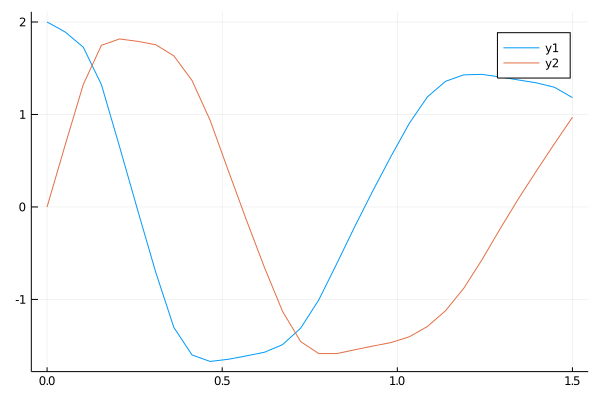

In [22]:
plot(prob_neuralode(u0, result_neuralode.minimizer).t, (prob_neuralode(u0, result_neuralode.minimizer) |> Array)' |> cpu)